In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle 
import random
from PIL import Image
import matplotlib.pyplot as plt
from random import sample
from datetime import datetime


from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from tensorflow.keras.models import load_model



## classes 
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

## Exploratory Data Analysis. Show at least the following:

In [2]:
def unpickle(file):   

    with open(file, 'rb') as fo:       
        dict = pickle.load(fo, encoding='bytes')   
    return dict

## Show the shape of the datasets.

In [3]:
def load_data(data_dir):#load training data 
    for i in range(1, 6): 
        filename = data_dir+"data_batch_"+str(i) 
        dictionary = unpickle(filename)
        x_data = dictionary[b'data']  
        print("This is batch",i, "'s data shape ", x_data.shape, sep = '')
        y_data = np.array(dictionary[b"labels"])
        if i==1:   
            X = x_data  
            y= y_data  
        else:  
            X = np.concatenate((X, x_data), axis = 0)   
            y = np.concatenate((y, y_data), axis = 0)  #load testing data
    filename = data_dir+"test_batch" 
    dictionary = unpickle(filename)
    data = dictionary[b"data"]
    print("This is test batch's data shape ", data.shape, sep = '')
    x_test = data 
    y_test = np.array(dictionary[b"labels"]) 
    return X, y, x_test, y_test

(X, y, x_test, y_test) = load_data("cifar-10-python/cifar-10-batches-py/")

This is batch1's data shape (10000, 3072)
This is batch2's data shape (10000, 3072)
This is batch3's data shape (10000, 3072)
This is batch4's data shape (10000, 3072)
This is batch5's data shape (10000, 3072)
This is test batch's data shape (10000, 3072)


In [4]:
print(X.shape)
print(y.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


## Render 5 images from each label to show that you know how to assemble an image from the dataset.

In [5]:
X = X.reshape(len(X),3,32,32).transpose(0,2,3,1)
x_test = x_test.reshape(len(x_test),3,32,32).transpose(0,2,3,1)
print(X.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
idx = {v: np.where(y == v)[0].tolist() for v in np.unique(y)}
first5 = []
for i in idx.values():
    first5.append((i[:5]))
first5

[[29, 30, 35, 49, 77],
 [4, 5, 32, 44, 45],
 [6, 13, 18, 24, 41],
 [9, 17, 21, 26, 33],
 [3, 10, 20, 28, 34],
 [27, 40, 51, 56, 70],
 [0, 19, 22, 23, 25],
 [7, 11, 12, 37, 43],
 [8, 62, 69, 92, 100],
 [1, 2, 14, 15, 16]]

Label: 0


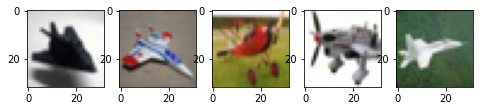

Label: 1


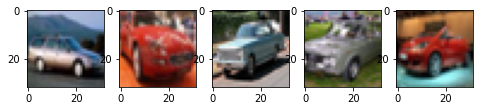

Label: 2


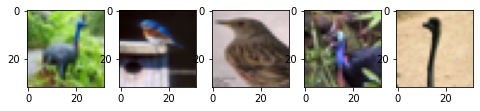

Label: 3


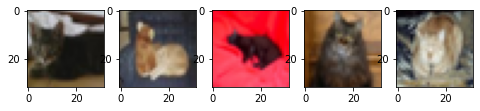

Label: 4


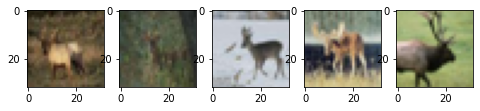

Label: 5


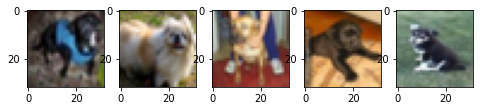

Label: 6


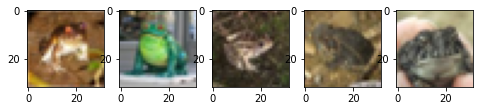

Label: 7


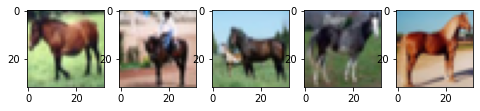

Label: 8


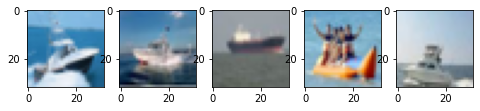

Label: 9


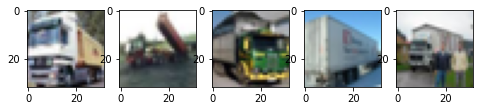

In [7]:
columns= 5
rows = 1
for j in range(0,10):
    fig = plt.figure(figsize = (8,8))
    for i in range(1,6):
        fig.add_subplot(rows,columns,i)
        plt.imshow(X[first5[j][i-1]])
    print("Label: ",j, sep = '')
    plt.show()

## Pick ONE label that you will be using for probabability that the item/animal is there.

## I choose frog label 6

## Data Processing. Do at least the following:

##  Obtain your training and testing dataset. Use the data batches as how they are meant to be used.

## Ensure that there is no data imbalance between the images belonging to the label you selected. Simply, there should be 10000 data entries for training and 2000 for testing.

In [8]:

random_var = random.sample(range(0,10000), 5000)
len(random_var)

5000

In [9]:
X_frog_train1 = X[idx[6][0:5000]]
X_frog_train2 = X[random_var]

In [10]:
X_frog_train = np.vstack((X_frog_train1, X_frog_train2))
print(len(X_frog_train))

10000


In [11]:
y_frog_train1 = y[idx[6][0:5000]]
y_frog_train2 = y[random_var]
y_frog_train = np.hstack((y_frog_train1, y_frog_train2))
print(len(y_frog_train))

unique, counts = np.unique(y_frog_train, return_counts=True)
print(np.asarray((unique, counts)).T)

10000
[[   0  517]
 [   1  486]
 [   2  501]
 [   3  522]
 [   4  498]
 [   5  460]
 [   6 5527]
 [   7  487]
 [   8  524]
 [   9  478]]


In [12]:
random_var2 = random.sample(range(0,2000), 1000)
len(random_var2)
idx_test = {v: np.where(y_test == v)[0].tolist() for v in np.unique(y_test)}

In [13]:
X_frog_test1 = x_test[idx_test[6][0:1000]]
X_frog_test2 = x_test[random_var2]

X_frog_test = np.vstack((X_frog_test1, X_frog_test2))
print(len(X_frog_test))

2000


In [14]:
y_frog_test1 = y_test[idx_test[6][0:1000]]
y_frog_test2 = y_test[random_var2]

y_frog_test = np.hstack((y_frog_test1, y_frog_test2))
print(len(y_frog_test))
unique, counts = np.unique(y_frog_test, return_counts=True)
print(np.asarray((unique, counts)).T)

2000
[[   0  114]
 [   1   91]
 [   2   99]
 [   3   93]
 [   4  119]
 [   5   97]
 [   6 1107]
 [   7   89]
 [   8  102]
 [   9   89]]


In [15]:
asdfasdf = np.where(y_frog_test != 6)
y_frog_test[asdfasdf] = 0
asdfasdf1 = np.where(y_frog_test == 6)
y_frog_test[asdfasdf1] = 1

y_frog_test

array([1, 1, 1, ..., 0, 1, 0])

In [16]:
asdfasdf2 = np.where(y_frog_train != 6)    
y_frog_train[asdfasdf2] = 0
asdfasdf3 = np.where(y_frog_train == 6)    
y_frog_train[asdfasdf3] = 1

y_frog_train

array([1, 1, 1, ..., 0, 0, 0])

In [17]:
unique, counts = np.unique(y_frog_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 4473]
 [   1 5527]]


In [18]:
unique, counts = np.unique(y_frog_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  893]
 [   1 1107]]


0


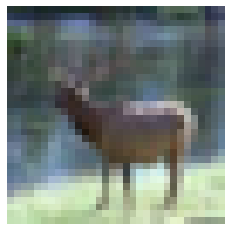

0


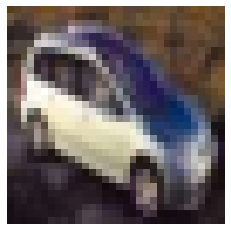

0


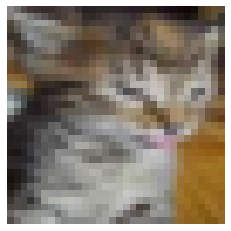

0


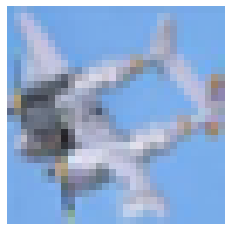

0


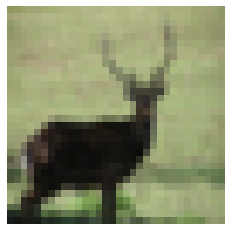

1


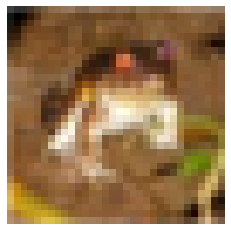

1


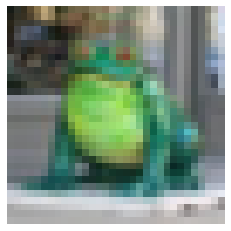

1


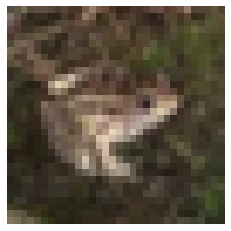

1


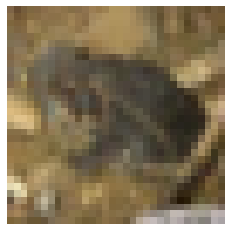

1


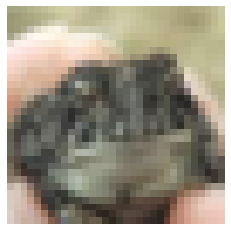

In [19]:
for i in range(-5, 5):
    plt.imshow(X_frog_train[i])
    print(y_frog_train[i])
    plt.axis('off')
    plt.show()

0


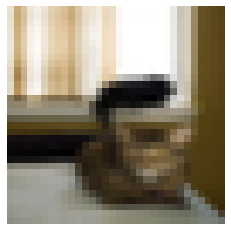

0


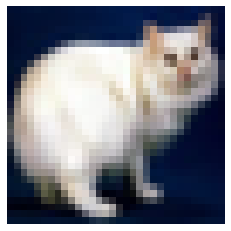

0


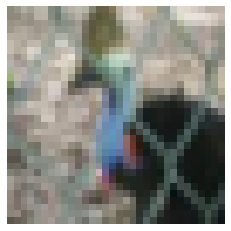

1


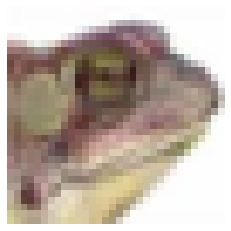

0


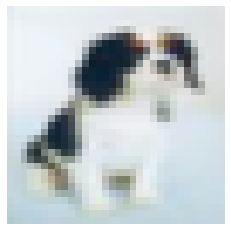

1


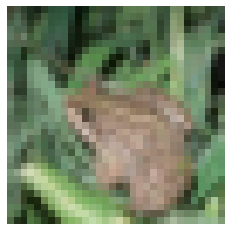

1


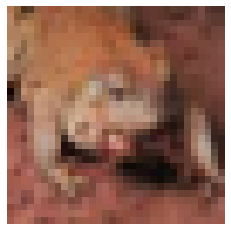

1


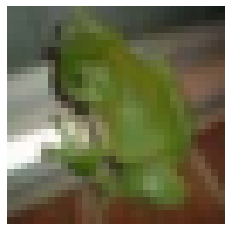

1


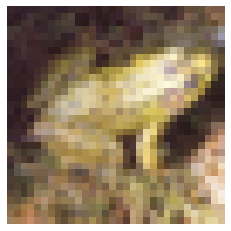

1


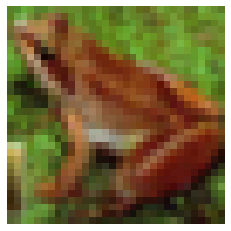

In [20]:
for i in range(-5, 5):
    plt.imshow(X_frog_test[i])
    print(y_frog_test[i])
    plt.axis('off')
    plt.show()

In [21]:
y_frog_test_encode = tf.one_hot(y_frog_test, depth=10)
y_frog_train_encode = tf.one_hot(y_frog_train, depth=10)

## Data Modelling.

Create your Model. A skeleton notebook with example Neural Network is provided. 

Feel free to change the shape of your model:
Adding/changing hidden layers with their node counts and activation types.
Changing the optimizer, loss and the metric for the output.
Feel free to change the input and output if you know what you are doing.
Fit your training and validation (testing in this case) dataset to the model.

In [22]:
def generateModel(hp=None):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=X_frog_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
        
    return model

In [23]:
generateModel().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 30, 30, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                        

In [24]:
model = generateModel()

In [25]:
# Normalizing the input image
X_frog_train = X_frog_train.astype('float32')
X_frog_test = X_frog_test.astype('float32')

# Normalizing the input image
X_frog_train /= 255
X_frog_test /= 255

In [26]:
history = model.fit(X_frog_train, y_frog_train_encode,
          epochs=30,
          validation_data=(X_frog_test, y_frog_test_encode),
          batch_size=100,
          )

Epoch 1/30
100/100 [==============================] - 47s 466ms/step - loss: 9.8207 - accuracy: 0.7380 - val_loss: 10.8992 - val_accuracy: 0.3205
Epoch 2/30
100/100 [==============================] - 47s 468ms/step - loss: 9.1158 - accuracy: 0.8069 - val_loss: 9.8501 - val_accuracy: 0.4460
Epoch 3/30
100/100 [==============================] - 47s 467ms/step - loss: 8.7060 - accuracy: 0.8417 - val_loss: 9.2405 - val_accuracy: 0.5075
Epoch 4/30
100/100 [==============================] - 47s 468ms/step - loss: 8.3482 - accuracy: 0.8575 - val_loss: 8.5559 - val_accuracy: 0.6635
Epoch 5/30
100/100 [==============================] - 47s 466ms/step - loss: 8.0096 - accuracy: 0.8690 - val_loss: 7.8736 - val_accuracy: 0.8665
Epoch 6/30
100/100 [==============================] - 47s 468ms/step - loss: 7.6891 - accuracy: 0.8752 - val_loss: 7.5245 - val_accuracy: 0.8805
Epoch 7/30
100/100 [==============================] - 47s 469ms/step - loss: 7.3856 - accuracy: 0.8872 - val_loss: 7.2250 - val_a

In [27]:
# save model
model.save('model.h5')

In [28]:
# load model
#model = load_model('model.h1')
# evaluate model
model.evaluate(X_frog_test, y_frog_test_encode)

63/63 [==============================] - 3s 43ms/step - loss: 3.0913 - accuracy: 0.8850


[3.091346025466919, 0.8849999904632568]

from this we see test accuracy of 86.35% and loss of 3.15 which is approaching 0.

## Advance Features
## Takes and image resizes it 

In [29]:
def image_resize(image):
    image = image.resize((32,32), Image.ANTIALIAS)
    image = np.array(image)
    image = image[:,:,:3]
    image = image.reshape(32, 32, 3)
    return model.predict(np.array([image]))

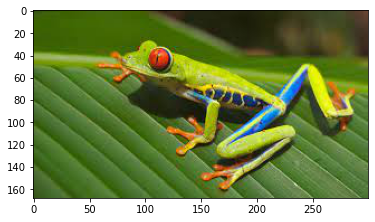

In [30]:
image = Image.open('frog.jpg')
plt.imshow(image)

In [31]:
image_resize(image)

1/1 [==============================] - 0s 172ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## hyperparameter tuning 

In [32]:
def model_eval(model, X_test, y_test):
    eval_d = model.evaluate(X_test, y_test, return_dict=True)
    display_df = pd.DataFrame([eval_d.values()], columns=[list(eval_d.keys())])
    return display_df

In [33]:
tuner = kt.RandomSearch(
    generateModel,
    objective='val_accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='new_final')

INFO:tensorflow:Reloading Oracle from existing project my_dir\new_final\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\new_final\tuner0.json


In [34]:
tuner.search(X_frog_train, y_frog_train_encode,
             epochs=15,
             validation_data=(X_frog_test, y_frog_test_encode))

INFO:tensorflow:Oracle triggered exit


In [35]:
# find best possible model compilation parameters for accuracy
best_hps=tuner.get_best_hyperparameters()[0]
new_model = tuner.hypermodel.build(best_hps)


In [36]:
new_model.fit(X_frog_train, y_frog_train_encode,
          validation_data=(X_frog_test, y_frog_test_encode),
          epochs=15,
          batch_size=100,
          )

Epoch 1/15
100/100 [==============================] - 48s 475ms/step - loss: 9.8636 - accuracy: 0.7305 - val_loss: 10.7192 - val_accuracy: 0.5500
Epoch 2/15
100/100 [==============================] - 47s 466ms/step - loss: 9.1147 - accuracy: 0.8066 - val_loss: 9.3528 - val_accuracy: 0.5045
Epoch 3/15
100/100 [==============================] - 46s 465ms/step - loss: 8.7124 - accuracy: 0.8371 - val_loss: 8.8985 - val_accuracy: 0.5935
Epoch 4/15
100/100 [==============================] - 52s 522ms/step - loss: 8.3494 - accuracy: 0.8539 - val_loss: 8.3213 - val_accuracy: 0.7780
Epoch 5/15
100/100 [==============================] - 56s 564ms/step - loss: 8.0038 - accuracy: 0.8686 - val_loss: 7.9319 - val_accuracy: 0.8240
Epoch 6/15
100/100 [==============================] - 52s 520ms/step - loss: 7.6932 - accuracy: 0.8774 - val_loss: 7.5223 - val_accuracy: 0.8850
Epoch 7/15
100/100 [==============================] - 54s 537ms/step - loss: 7.3898 - accuracy: 0.8792 - val_loss: 7.2258 - val_a

In [37]:
results = model_eval(model, X_frog_test, y_frog_test_encode)
results

63/63 [==============================] - 3s 50ms/step - loss: 3.0913 - accuracy: 0.8850


,loss,accuracy
0,3.091346,0.885


In [38]:
random_search_df = model_eval(new_model, X_frog_test, y_frog_test_encode)
random_search_df.index = ['randomsearch_tuned']
results = results.append(random_search_df)
results.index = ['baseline', 'randomsearch_tuned']

results

63/63 [==============================] - 3s 48ms/step - loss: 5.3553 - accuracy: 0.8800


C:\Users\jordan\AppData\Local\Temp\ipykernel_8980\611181171.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(random_search_df)


,loss,accuracy
baseline,3.091346,0.885
randomsearch_tuned,5.355312,0.880


We see increased accuracy at the cost of increased loss, which i do not think is worth the increase in accuracy.


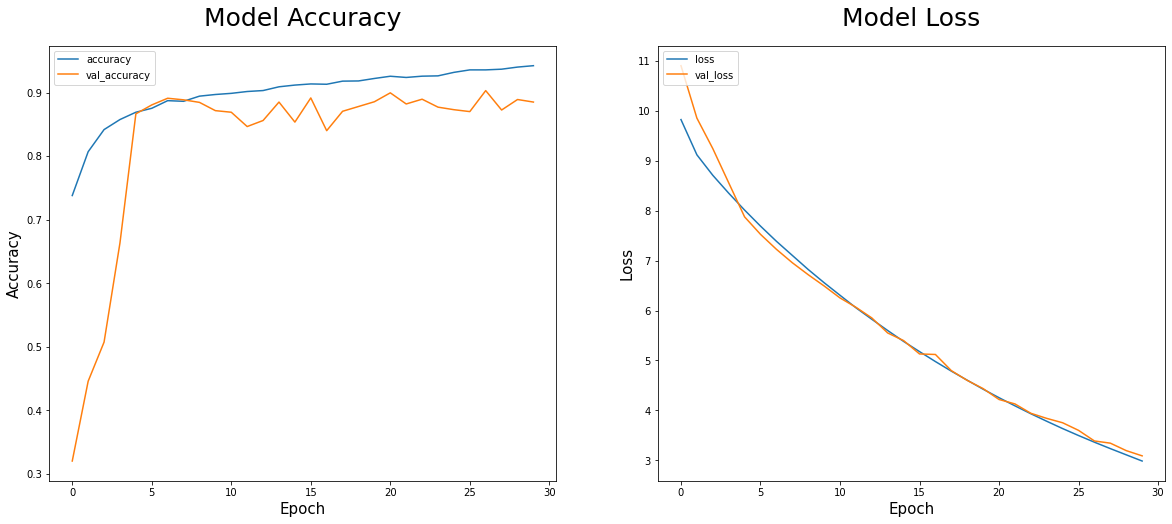

In [39]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

63/63 [==============================] - 3s 45ms/step


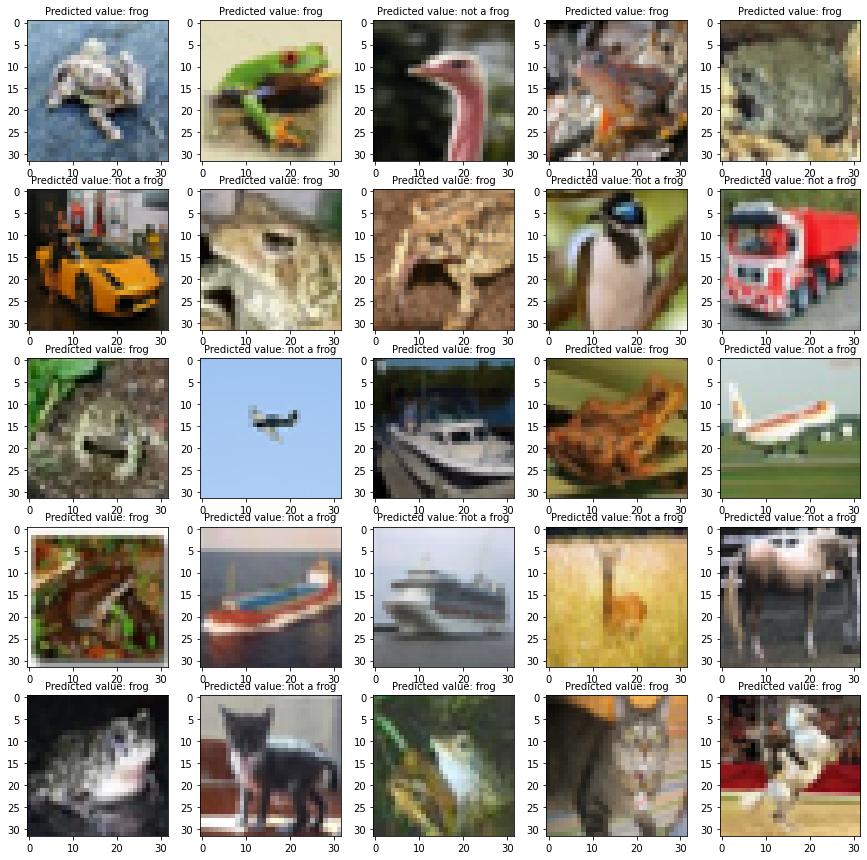

In [40]:
columns= 5
rows = 5

class_names = ["not a frog", "frog"]

res = random.sample(range(1, 2001), 25)
fig = plt.figure(figsize = (15,15))
predictions = model.predict(X_frog_test)

for i in range(1,26):
    lol = res[i-1]
    fig.add_subplot(rows,columns,i)
    plt.imshow(X_frog_test[lol].reshape(32, 32, -1), cmap=plt.cm.binary)
    plt.title("Predicted value: " + str(class_names[np.argmax(predictions[lol], axis=0)]), size=10)
plt.show()